# CSE527 Homework 5 - 1
**Due date: 11:59 pm EST on Dec. 1, 2022 (Thu.)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

## Enable Colab GPU Acceleration
---
Navigation menu: **Runtime->Change runtime type->Hardware accelerator->GPU**

## Local Machine Prerequisites
---
Since we are using Google Colab, all the code is run on the server environment where lots of libraries or packages have already been installed. In case of missing 
 libraries or if you want to install them in your local machine, below are the links for installation.
* **Install Python 3.6.9**: https://www.python.org/downloads/ or use Anaconda (a Python distribution) at https://docs.continuum.io/anaconda/install/. Below are some materials and tutorials which you may find useful for learning Python if you are new to Python.
  - https://docs.python.org/3.6/tutorial/index.html
  - https://www.learnpython.org/
  - https://docs.opencv.org/4.1.2/d6/d00/tutorial_py_root.html
  - http://www.scipy-lectures.org/advanced/image_processing/index.html


* **Install Python packages**: install Python packages: `numpy`, `matplotlib`, `opencv-python` using pip, for example:
```
pip install numpy matplotlib opencv-python
``` 
	Note that when using “pip install”, make sure that the version you are using is python3. Below are some commands to check which python version it uses in you machine. You can pick one to execute:
  
```
    pip show pip
    pip --version
    pip -V
```

In case of the wrong version, use `pip3` for python3 explictly.

* **Install Jupyter Notebook**: follow the instructions at http://jupyter.org/install.html to install Jupyter Notebook and familiarize yourself  with it. *After you have installed Python and Jupyter Notebook, please open this notebook file with your Jupyter Notebook and do your homework there.*


## Description
---
In this homework, we will implement an image-to-image translation method, based on
[pix2pix](https://phillipi.github.io/pix2pix/). To be more specific,  we'll built from scratch a GAN which can translate abstract labels into facade images. 

Before we start, please read the [pix2pix paper](https://arxiv.org/pdf/1611.07004.pdf) first and understand how pix2pix works.

There are 6 parts + 1 bonus part in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important.

**Do not upload** the data subfolder or trained models before submitting on blackboard due to the size limit.


## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Replace '------' with the path such that "Surname_Givenname_SBUID_hw*" is your working directory
%cd '/content/gdrive/MyDrive/SBU /Fall 22/Courses/CSE 527 Introduction to Computer Vision/Assignments/Kansara_ParthSandip_115135130_hw5'

/content/gdrive/MyDrive/SBU /Fall 22/Courses/CSE 527 Introduction to Computer Vision/Assignments/Kansara_ParthSandip_115135130_hw5


### Part 1 Load dataset
---

We'll train a model to generate pictures of facades from label maps, using the [CMP Facade
Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) . This dataset contains 606 rectified images of facades from various sources, which have been manually annotated.

**{10 points}** For the training process, we will use a batch size equal to `1`, as in the original paper. During testing, we will process `4` images in a single batch, so that we can visualize
several results at once.

Load the training set and test set under the folder `./facades`. Normalize the images to $[-1, 1]$. For each set, return a batch list. Show one image from the training set and its label side by side in a `1x2` grid.

In [ ]:
# download the dataset
! chmod +x ./download_dataset.sh
! ./download_dataset.sh
!tar -xzvf "facades.tar.gz" -C "/content/gdrive/MyDrive/SBU /Fall 22/Courses/CSE 527 Introduction to Computer Vision/Assignments/Kansara_ParthSandip_115135130_hw5" 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import imageio

In [ ]:
# Checking GPU
if torch.cuda.is_available():
  cuda = True
  Tensor =  torch.cuda.FloatTensor
  device = torch.device("cuda")
else:
  cuda = False
  Tensor = torch.FloatTensor
  device = torch.device("cpu")

Variable = torch.autograd.Variable
print(device)

cuda


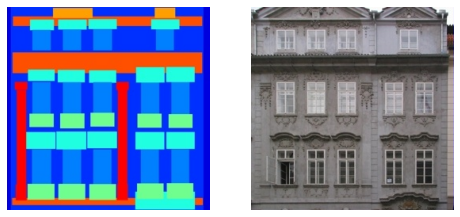

In [ ]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def load_dataset(path, shuffle=False):
    # load the images under the folder
    # remember to normalize them to [-1, 1]
    image_names = [name for name in glob.glob(path + '/*.jpg')]
    data = []
    ##########--WRITE YOUR CODE HERE--##########
    for img in image_names:
        img = cv2.imread(img)
        height, width, depth = img.shape     
        w = width//2
        s_left  = img[:, :w, :]
        s_right = img[:, w:, :]
        s_right = torch.from_numpy(np.transpose(normalizeImage(s_right), [2, 0, 1]))
        s_left = torch.from_numpy(np.transpose(normalizeImage(s_left), [2, 0, 1]))
        data.append((s_right,s_left)) 
    
    ##########-------END OF CODE-------##########
    # return a list of tuples.
    # for each tuple, the first element is ground truth, the second one is label image
    # both images should be tensors
    return data

def normalizeImage (img):
  normalizedImage = cv2.normalize(img, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  return normalizedImage

set_seeds(302)
train = load_dataset('./facades/train', shuffle=True)
test = load_dataset('./facades/test')


def show_img_pair(s_left, s_right):
    # convert the pixels back to [0, 1] when visualizing
    
    ##########--WRITE YOUR CODE HERE--##########
    s_left = np.transpose(s_left.numpy(), [1,2,0]) * 0.5 + 0.5
    s_right = np.transpose(s_right.numpy(), [1,2,0]) * 0.5 + 0.5
    s_left = cv2.cvtColor(np.float32(s_left), cv2.COLOR_BGR2RGB)
    s_right = cv2.cvtColor(np.float32(s_right), cv2.COLOR_BGR2RGB)
    figure, axis = plt.subplots(1, 2, figsize=(8,4))

    axis[0].imshow(s_left)
    axis[0].axis('off')

    axis[1].imshow(s_right)
    axis[1].axis('off')
    
    ##########-------END OF CODE-------##########    
    
    
idx = 150
show_img_pair(train[idx][0], train[idx][1])

### Part 2 Models
---
In this part, we will define the network based on the architectures from the paper.
Please check the Appendix of the paper for the details of this architecture.

Let $Ck$ denote a Convolution-BatchNorm-ReLU layer with k filters. $CDk$
denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of 50%. All
convolutions are 4 x 4 spatial filters applied with stride 2. Convolutions in the encoder,
and in the discriminator, downsample the input by a factor of 2, whereas in the decoder
they upsample the input by a factor of 2.

#### **{15 points}** (a) Generator
The U-Net encoder-decoder architecture consists of:

U-Net encoder:
$$C64-C128-C256-C512-C512-C512-C512-C512$$

U-Net decoder:

$$CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128$$

After the last layer in the decoder, a convolution is applied to map to the number
of output channels, which is `3` in our problem, followed by a `tanh` function. As a
special case, batch normalization is not applied to the first $C64$ layer in the encoder.
All ReLUs in the encoder are leaky, with slope `0.2`, while ReLUs in the decoder are
not leaky.
If you are not familiar with the architecture of UNet, please check [this paper](https://arxiv.org/abs/1505.04597) first.

#### **{15 points}** (b) Discriminator

The discriminator architecture is:
$$C64-C128-C256-C512$$
After the last layer, a convolution is applied to map to a 1-dimensional output,
followed by a sigmoid function. As an exception to the above notation, batch
normalization is not applied to the first $C64$ layer. All ReLUs are leaky, with slope
`0.2`.

Hint: Use `torch.nn.functional.leaky_relu` for leaky ReLU.

In [ ]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        #Discriminator: Conv 64 > Conv 128 > Conv 256 > Conv 512

        #Convolutional Layer 1
        self.conv1 = nn.Conv2d(n_channels*2, 64, 4, 2, 1)

        #Convolutional Layer 2
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(128)

        #Convolutional Layer 3
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(256)

        #Convolutional Layer 4
        self.conv4 = nn.Conv2d(256, 512, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(512)

        #Convolutional Layer 5
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 1)
        ##########-------END OF CODE-------##########
        
    def forward(self, x):
        ##########--WRITE YOUR CODE HERE--##########
        x = torch.cat([x[0], x[1]], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x_d = F.sigmoid(self.conv5(x))        
        ##########-------END OF CODE-------##########
        return x_d

##########--WRITE YOUR CODE HERE--##########    
netD = Discriminator(3)
# feel free to do some sanity check here

##########-------END OF CODE-------##########    

In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, n_channels):
        super(GeneratorUNet, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        # Unet encoder: 𝐶64−𝐶128−𝐶256−𝐶512−𝐶512−𝐶512−𝐶512−𝐶512
        #Convolutional Layer 1
        self.conv1 = nn.Conv2d(n_channels, 64, 4, 2, 1)

        #Convolutional Layer 2
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(128)

        #Convolutional Layer 3
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(256)

        #Convolutional Layer 4
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(512)

        #Convolutional Layer 5
        self.conv5 = nn.Conv2d(512, 512, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(512)

        #Convolutional Layer 6
        self.conv6 = nn.Conv2d(512, 512, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(512)

        #Convolutional Layer 7
        self.conv7 = nn.Conv2d(512, 512, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(512)

        #Convolutional Layer 8
        self.conv8 = nn.Conv2d(512, 512, 4, 2, 1)
        
        # Unet decoder : 𝐶𝐷512−𝐶𝐷1024−𝐶𝐷1024−𝐶1024−𝐶1024−𝐶512−𝐶256−𝐶128

        #Deconvolutional Layer 1
        self.deconv1 = nn.ConvTranspose2d(512, 512, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(512)

        #Deconvolutional Layer 2
        self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(512)

        #Deconvolutional Layer 3
        self.deconv3 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(512)

        #Deconvolutional Layer 4
        self.deconv4 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(512)

        #Deconvolutional Layer 5
        self.deconv5 = nn.ConvTranspose2d(1024, 256, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(256)

        #Deconvolutional Layer 6
        self.deconv6 = nn.ConvTranspose2d(512, 128, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(128)

        #Deconvolutional Layer 7
        self.deconv7 = nn.ConvTranspose2d(256, 64, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(64)

        #Deconvolutional Layer 8
        self.deconv8 = nn.ConvTranspose2d(128, 3, 4, 2, 1)        
        ##########-------END OF CODE-------##########
    
    def forward(self, x):   
        ##########--WRITE YOUR CODE HERE--##########
        # Encoder Layers
        e1 = self.conv1(x)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))

        # Decoder Layers
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)

        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)

        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)

        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        d4 = torch.cat([d4, e4], 1)

        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)

        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)

        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        
        d8 = self.deconv8(F.relu(d7))
        x_g = F.tanh(d8)

        ##########-------END OF CODE-------##########
        return x_g


##########--WRITE YOUR CODE HERE--##########    
# netG = # initialize the discriminator
netG = GeneratorUNet(3)
netGL1 = GeneratorUNet(3)
# feel free to do some sanity check here

##########-------END OF CODE-------##########  

### Part 3 Optimizor
---
**{5 points}** For optimization, we'll use the Adam optimizer, with a learning rate of `0.0002`, and momentum parameters  $\beta_1= 0.5$; $\beta_2 = 0.999$.

In [ ]:
# Define the optimizors here, make sure you give them the right parameters

##########--WRITE YOUR CODE HERE--########## 
optim_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_GL1 = optim.Adam(netGL1.parameters(), lr=0.0002, betas=(0.5, 0.999))
##########-------END OF CODE-------##########

### Part 4 Training
---
**{20 points}** For each batch, first train discriminator D by using the average loss of real image and fake image. Then train generator G by using the following loss equation.
$$G^*=\arg \min_{G} \max_{D} L_{cGAN}(G, D) + \lambda L_{L1}(G) $$

In this homework, you will train two different models: one using only the L1 loss, the other using the equation above with $\lambda = 100$. 

As a sanity check, please compare your results with those in the paper (e.g. Figure 4) to make sure they roughly match.

Train the network for at least 20 epochs (at least 10 epochs for the model with only L1 loss,) but you are encouraged to train longer to obtain better results. (In the paper, they train
for 200 epochs.) Save your models to `pix2pix.pth` and `pix2pixL1.pth` using the given code. 

Note: Training training each epoch should take less than 2 minutes if you are using Colab. **Remember to save your models regularly** so you won't lose your progress accidentally.

**{5 points}** In the end, plot the Generator/Discriminator (G/D) loss history (averaged per epoch) of the two models with respect to the epoch in two plots. i.e. the first plot should contain the G/D loss of the model with L1 and cGAN, the second plot should contain the L1 loss of the other model.


In [ ]:
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = netG.to(device)
netD = netD.to(device)
netG.train()
netD.train()

##########--WRITE YOUR CODE HERE--########## 

def load_image(file):
    img = PIL.Image.open(file)
    img1 = img.crop((256,0,512,256))
    img2 = img.crop((0,0,256,256))
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    return transform(img1), transform(img2)

class buildData(Dataset):
    def __init__(self, mode):
        self.files = glob.glob('%s/%s/*'%('facades', mode))

    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        a, b = load_image(self.files[idx])
        return a, b

def train_model(netG, netD, optim_G, optim_D, train_loader, epoch):

    G_loss, D_loss = [], []
    gan_loss = F.binary_cross_entropy_with_logits

    for i, (a, b) in enumerate(train_loader):

        a, b = a.to(device), b.to(device)
  
        realImage, facadeImage = torch.ones((a.size(0), 1, 30, 30)).to(device) , torch.zeros((a.size(0), 1, 30, 30)).to(device)

        optim_G.zero_grad()
        facadeImage_b = netG(a)
        pred = netD((a, facadeImage_b))
        loss_G = gan_loss(pred, realImage) + F.l1_loss(b, facadeImage_b) * 100

        loss_G.backward()
        optim_G.step()

        optim_D.zero_grad()

        pred_realImage, pred_facadeImage= netD((a, b)), netD((a, facadeImage_b.detach()))

        loss_realImage, loss_facadeImage = gan_loss(pred_realImage, realImage), gan_loss(pred_facadeImage, facadeImage)

        loss_D = (loss_realImage + loss_facadeImage) * 0.5

        loss_D.backward()
        optim_D.step()

        G_loss.append(loss_G.item())
        D_loss.append(loss_D.item())

        if (i+1) % 25 == 0:
            g_mean, d_mean = np.mean(G_loss[-10:]), np.mean(D_loss[-10:])
            print("\rEpoch %d \t Sample Count %d/%d \t Gen loss: %f \t Dis loss: %f" %
                    (epoch, i, len(train_loader), g_mean, d_mean))

    return np.mean(G_loss), np.mean(D_loss)

train_loader = DataLoader(buildData("train"), 1, shuffle=True)

epochs = 80
G_losses = []
D_losses =[]
G_by_D_Loss = []
for epoch in range(epochs):
        G_loss, D_loss = train_model(netG, netD, optim_G, optim_D, train_loader, epoch)

        print('\nGen Loss = %.4f \t Dis Loss = %.4f \t Ratio of Losses = %.4f\n'%(G_loss, D_loss, G_loss/D_loss))
        G_losses.append(G_loss)
        D_losses.append(D_loss)
        G_by_D_Loss.append (G_loss / D_loss)
##########-------END OF CODE-------##########

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 	 Sample Count 24/400 	 Gen loss: 43.793803 	 Dis loss: 0.630024
Epoch 0 	 Sample Count 49/400 	 Gen loss: 42.766567 	 Dis loss: 0.607265
Epoch 0 	 Sample Count 74/400 	 Gen loss: 40.307078 	 Dis loss: 0.577590
Epoch 0 	 Sample Count 99/400 	 Gen loss: 39.079221 	 Dis loss: 0.560011
Epoch 0 	 Sample Count 124/400 	 Gen loss: 37.981075 	 Dis loss: 0.557444
Epoch 0 	 Sample Count 149/400 	 Gen loss: 34.963968 	 Dis loss: 0.596015
Epoch 0 	 Sample Count 174/400 	 Gen loss: 36.197767 	 Dis loss: 0.573956
Epoch 0 	 Sample Count 199/400 	 Gen loss: 37.032515 	 Dis loss: 0.580459
Epoch 0 	 Sample Count 224/400 	 Gen loss: 36.229199 	 Dis loss: 0.602395
Epoch 0 	 Sample Count 249/400 	 Gen loss: 38.955163 	 Dis loss: 0.557396
Epoch 0 	 Sample Count 274/400 	 Gen loss: 38.343112 	 Dis loss: 0.576288
Epoch 0 	 Sample Count 299/400 	 Gen loss: 40.973676 	 Dis loss: 0.543481
Epoch 0 	 Sample Count 324/400 	 Gen loss: 38.939044 	 Dis loss: 0.554812
Epoch 0 	 Sample Count 349/400 	 Gen loss:

In [ ]:
#Save model

torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    'epoch': epochs,
    'loss_G': G_losses,
    'loss_D': D_losses,
    }, 'pix2pix.pth')


In [ ]:
netGL1 = netGL1.to(device)
netGL1.train()

##########--WRITE YOUR CODE HERE--########## 
def modelTrain(netGL1, optim_G, train_loader, epoch):

    GL1_Loss = []

    for i, (a, b) in enumerate(train_loader):

        a = a.to(device)
        b = b.to(device)

        realImage, facadeImage = torch.ones((a.size(0), 1, 30, 30)).to(device), torch.zeros((a.size(0), 1, 30, 30)).to(device)
        
        optim_G.zero_grad()
        facadeImage1 = netGL1(a)
        G_Loss = F.l1_loss(b, facadeImage1)
        G_Loss.backward()

        optim_GL1.step()

        GL1_Loss.append(G_Loss.item())

        if (i+1) % 25 == 0:
            generatorMean = np.mean(GL1_Loss[-10:])
            print("Epoch %d \t Sample Count %d/%d \t GL1 loss: %f" %(epoch, i, len(train_loader), generatorMean))

        iters = epoch * len(train_loader) + i

    return np.mean(GL1_Loss)

L1_epochs = 50 
Final_Loss_GL1 = []

for epoch in range(L1_epochs):
  GL1_Loss = modelTrain (netGL1, optim_G, train_loader, epoch)
  torch.save({
          'G': netGL1.state_dict(),
          'epoch': L1_epochs,
          'loss': Final_Loss_GL1,
          }, 'pix2pixL1.pth')

  print('\nGL1_Loss: %.4f \n'%(GL1_Loss))
  Final_Loss_GL1.append(GL1_Loss)

##########-------END OF CODE-------##########

Epoch 0 	 Sample Count 24/400 	 GL1 loss: 0.416069
Epoch 0 	 Sample Count 49/400 	 GL1 loss: 0.414998
Epoch 0 	 Sample Count 74/400 	 GL1 loss: 0.389428
Epoch 0 	 Sample Count 99/400 	 GL1 loss: 0.430381
Epoch 0 	 Sample Count 124/400 	 GL1 loss: 0.446540
Epoch 0 	 Sample Count 149/400 	 GL1 loss: 0.477936
Epoch 0 	 Sample Count 174/400 	 GL1 loss: 0.451941
Epoch 0 	 Sample Count 199/400 	 GL1 loss: 0.396374
Epoch 0 	 Sample Count 224/400 	 GL1 loss: 0.434736
Epoch 0 	 Sample Count 249/400 	 GL1 loss: 0.415214
Epoch 0 	 Sample Count 274/400 	 GL1 loss: 0.466664
Epoch 0 	 Sample Count 299/400 	 GL1 loss: 0.399539
Epoch 0 	 Sample Count 324/400 	 GL1 loss: 0.432815
Epoch 0 	 Sample Count 349/400 	 GL1 loss: 0.444562
Epoch 0 	 Sample Count 374/400 	 GL1 loss: 0.445958
Epoch 0 	 Sample Count 399/400 	 GL1 loss: 0.465317

GL1_Loss: 0.4375 

Epoch 1 	 Sample Count 24/400 	 GL1 loss: 0.420551
Epoch 1 	 Sample Count 49/400 	 GL1 loss: 0.407814
Epoch 1 	 Sample Count 74/400 	 GL1 loss: 0.466941

In [ ]:
# codes for saving models, feel free to change them

# torch.save({
#     'G': netG.state_dict(),
#     'D': netD.state_dict(),
#     'epoch': epochs,
#     'loss_G': G_losses,
#     'loss_D': D_losses,
#     }, 'pix2pix.pth')

torch.save({
          'G': netGL1.state_dict(),
          'epoch': L1_epochs,
          'loss': Final_Loss_GL1,
          }, 'pix2pixL1.pth')

In [ ]:
# codes for restoring models, feel free to change them

path = "pix2pix.pth"
checkpoint = torch.load(path)
netG.load_state_dict(checkpoint['G'])
netD.load_state_dict(checkpoint['D'])
epoch = checkpoint['epoch']
G_loss = checkpoint['loss_G']
D_loss = checkpoint['loss_D']

path = "pix2pixL1.pth"
checkpoint = torch.load(path)
netGL1.load_state_dict(checkpoint['G'])
epoch_l1 = checkpoint['epoch']
GL1_loss = checkpoint['loss']

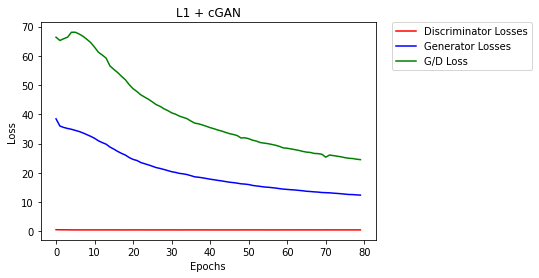

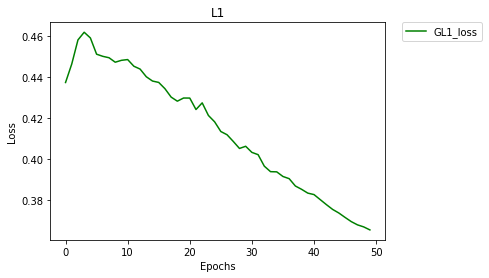

In [ ]:
plt.plot(D_losses , 'r', label= 'Discriminator Losses')
plt.plot(G_losses , 'b', label= 'Generator Losses')
plt.plot(G_by_D_Loss , 'g', label= 'G/D Loss')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('L1 + cGAN')
plt.show()

plt.plot(GL1_loss , 'g', label= 'GL1_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('L1')

plt.show()

### Part 5 Evaluation
---

Compared to a classification problem, evaluating an image translation model could be tricky because we don't always have the ground-truth available. There are several different ways to compare the performance of different GAN models:

1. Visualize the generated images of different GAN models. 

2. Compute a distance, such as **Frechet Inception Distance** (**FID**, the smaller the better, [paper](https://arxiv.org/abs/1706.08500)), between the generated images and the real images, or compute the Inception Score (**IS**, the higher the better, [paper](https://arxiv.org/pdf/1606.03498.pdf)) for the generated images. We strongly encourage you to read these papers.

3. Using generated images for downstream tasks, such as classification, segmentation, etc. and computing the task accuracy.

Now it's your turn to evaluate the models you trained. 

**{5 points}** We'll first visualize `4` test samples and plot them as in Figure 4 in the pix2pix paper, to get some qualitative results. You can select any interesting samples from the **test set**.

**{5 points}** Then let's do some quantitative analysis. Adapt this **Inception Score** ([ref](https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py)) implementation, and report the mean score of each model on the test set. Again, you are encouraged to train your models longer.

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


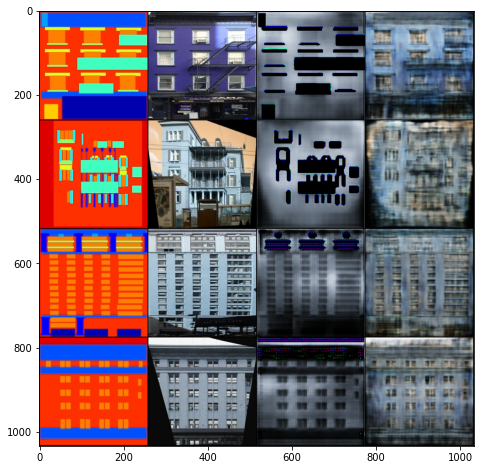

In [ ]:
# Visualization
# Please read Figure 4 in the pix2pix paper first

##########--WRITE YOUR CODE HERE--##########
import torchvision
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_loader = DataLoader(buildData("test"), 1, shuffle=True)
testImage = []

for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device)

    with torch.no_grad():
        facadeImage1, facadeImage1_L1 = netG(a), netGL1(a)

    testImage += [a[0], b[0], facadeImage1_L1[0],facadeImage1[0]]

    if j == 3:
        break

testImage = torch.stack(testImage).detach().cpu()
save_image(testImage, "testImage.png", nrow=4, normalize=True)

img = cv2.imread('testImage.png')
plt.figure(figsize = (8, 8))
imgplot = plt.imshow(img)

plt.show()

##########-------END OF CODE-------##########

In [ ]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def inception_score(images, splits=10):
    ##########--WRITE YOUR CODE HERE--##########
    n = len(images)
    sample_size = 1
    if sample_size > 0 and n > sample_size:

      dataloader = torch.utils.data.DataLoader(images, sample_size=sample_size)
      prediction = np.zeros((n, 1000))

      def getPredictedValue (x):
          x = inception_model(x)
          return F.softmax(x).data.cpu().numpy()      

      for i, sample in enumerate(dataloader, 0):
          sample = sample[0].type(dtype)
          samplev = Variable(sample)
          sample_size_i = sample.size()[0]

          prediction[i*sample_size:i*sample_size + sample_size_i] = getPredictedValue(samplev)

      split_scores = []

      for k in range(splits):
          part = prediction[k * (n // splits): (k+1) * (N // splits), :]
          py = np.mean(part, axis=0)
          scores = []
          for i in range(part.shape[0]):
              pyx = part[i, :]
              scores.append(entropy(pyx, py))
          split_scores.append(np.exp(np.mean(scores)))
      
      ##########-------END OF CODE-------##########
      return np.mean(split_scores)


# Get the translation on test set
##########--WRITE YOUR CODE HERE--##########
from torch.autograd import Variable

testPredictions = []
testPredictions_L1 = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = DataLoader(buildData("test"), 1, shuffle=True)

counter = 0

for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device)
    with torch.no_grad():
        facadeImage1 = netG(a)
        facadeImage1_L1 = netGL1(a)
    testPredictions.append(facadeImage1)
    testPredictions_L1.append(facadeImage1_L1)
    
##########-------END OF CODE-------##########

inception_s = inception_score(testPredictions)
inception_s_l1 = inception_score(testPredictions_L1)
from IPython.display import HTML, display
import tabulate
table = [["Loss","Inception Score"],
         ["L1 + cGAN", f"{inception_s:.4f}"],
         ["L1", f"{inception_s_l1:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-57-6c4bf08220e5>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


Loss,Inception Score
L1 + cGAN,2.0265
L1,3.8472


### Part 6 Understanding pix2pix
---
#### {5 points}Problem 1  
What image sizes can Pix2pix train with, and why can it handle different image sizes?

Hint: Explain this based on the generator and discriminator architectures.
<br>

Ans: <br>
 Any image sizes can be trained with Pix2pix since it uses PatchGAN, which permits images of different dimensions to be sent as inputs. Further, the output is used to represent specific "patches" of the input. 
<br><br><br>
#### {5 points}Problem 2 

Given an input image with size $256\times256\times6$ for the discriminator, write down the size of each neuron's receptive field after each layer, using the **discriminator** network architectures above:

e.g. $$Input → C64 → (?) → C128 →(?) → C256 → (?) → C512 → (?)$$

**Make sure you calculate the receptive field, not the size of the image.** 
<br>

Ans: <br>
For calculating the receptive field of layer N, we use the formula:
RF of Layer N = RF of Layer N-1 x stride + (Kernel_size - stride)

RF of Layer 1 = 4  <br>
RF of Layer 2 = 10  <br>
RF of Layer 3 = 22  <br>
RF of Layer 4 = 46  <br>
<br><br>
#### {5 points}Problem 3
Explain why minimizing only the L1 loss results in a blurry image. 
<br>

Ans: <br>
The loss function for L1 finds the Euclidean distance, which is minimized by finding the conditional pdf's median over the colors. Thus, L1 gives a blurry image when finding the location of an edge. 

<br><br><br>
#### {5 points}Problem 4
Why do we use PatchGAN in Pix2pix? 
<br>

Ans: <br>
Since PatchGAN gives better outputs, it is used in pix2pix. PatchGAN provides these better outputs by dividing the image into patches of 70 pixels by 70 pixels. This window of 70 x 70 is slid across the image and the outputs are averaged.

### {10 points} Bonus: Spectral Normalization

Spectral normalization (**SN**, [paper](https://arxiv.org/abs/1802.05957)) is a simple and useful technique for stabilizing GAN training. Replace `batch normalization` with `spectral normalization` in both discriminator and generator, train the new model with the same L1 and cGAN loss for at least 20 epochs, then save the model to `pix2pixSN.pth`. Finally, perform the same evaluation you did in part 5 and compare the performance of all the models you trained.

Hint: use `torch.nn.utils.spectral_norm`.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########

        #Discriminator: Conv 64 > Conv 128 > Conv 256 > Conv 512
        #Convolutional Layer 1
        self.conv1 = nn.Conv2d(n_channels*2, 64, 4, 2, 1)

        #Convolutional Layer 2
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)

        #Convolutional Layer 3
        self.conv3 = torch.nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1))

        #Convolutional Layer 4
        self.conv4 = torch.nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, 1, 1))

        #Convolutional Layer 5
        self.conv5 = torch.nn.utils.spectral_norm(nn.Conv2d(512, 1, 4, 1, 1))
        ##########-------END OF CODE-------##########
        
    def forward(self, x):
        ##########--WRITE YOUR CODE HERE--##########
        x = torch.cat([x[0], x[1]], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu((self.conv2(x)), 0.2)
        x = F.leaky_relu((self.conv3(x)), 0.2)
        x = F.leaky_relu((self.conv4(x)), 0.2)
        x_d = F.sigmoid(self.conv5(x))        
        ##########-------END OF CODE-------##########
        return x_d

##########--WRITE YOUR CODE HERE--##########    
# netD = # initialize the discriminator
netD = Discriminator(3)
# feel free to do some sanity check here

##########-------END OF CODE-------##########    


In [ ]:
from torch.nn.utils import spectral_norm

class Conv (torch.nn.Module):
    def __init__(self, inputChannels, outputChannels, kernel_size=4, stride=2, padding=1, activation=True, spectral_norm=True):
        super(Conv , self).__init__()
        self.conv = torch.nn.Conv2d(inputChannels, outputChannels, kernel_size, stride, padding)
        self.activation = activation
        self.leaky = torch.nn.LeakyReLU(0.2, True)
        self.spectral_norm = spectral_norm

    def forward(self, x):
        if self.activation:
            out = self.conv(self.leaky(x))
            
        else:
            out = self.conv(x)

        return out
        
class DeConv (torch.nn.Module):
    def __init__(self, inputChannels, outputChannels, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeConv , self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(inputChannels, outputChannels, kernel_size, stride, padding)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.spectral_norm = spectral_norm
        self.dropout = dropout

    def forward(self, x):
        out = self.deconv(self.relu(x))
        if self.dropout:
            return self.drop(out)
        else:
            return out
        
class Generator(torch.nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        # Unet encoder: 𝐶64−𝐶128−𝐶256−𝐶512−𝐶512−𝐶512−𝐶512−𝐶512
        self.conv1 = Conv (input_dim, 64, activation=False, spectral_norm=True)
        self.conv2 = Conv (64, 128)
        self.conv3 = Conv (128, 256)
        self.conv4 = Conv (256, 512)
        self.conv5 = Conv (512, 512)
        self.conv6 = Conv (512, 512)
        self.conv7 = Conv (512, 512)
        self.conv8 = Conv (512, 512, spectral_norm=True)

        # Unet decoder : 𝐶𝐷512−𝐶𝐷1024−𝐶𝐷1024−𝐶1024−𝐶1024−𝐶512−𝐶256−𝐶128
        self.deconv1 = DeConv (512, 512, dropout=True)
        self.deconv2 = DeConv (1024, 512, dropout=True)
        self.deconv3 = DeConv (1024, 512, dropout=True)
        self.deconv4 = DeConv (1024, 512)
        self.deconv5 = DeConv (1024, 256)
        self.deconv6 = DeConv (256 * 2, 128)
        self.deconv7 = DeConv (128 * 2, 64)
        self.deconv8 = DeConv (128, 3)

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)

        dec1 = self.deconv1(enc8)
        dec1 = torch.cat([dec1, enc7], 1)

        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc6], 1)

        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc5], 1)

        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc4], 1)

        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc3], 1)

        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc2], 1)

        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc1], 1)

        dec8 = self.deconv8(dec7)
        out = torch.nn.Tanh()(dec8)

        return out
    
netG = Generator(3)
netGL1 = Generator(3)

In [ ]:
# Define the optimizors here, make sure you give them the right parameters

##########--WRITE YOUR CODE HERE--########## 
optim_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_GL1 = optim.Adam(netGL1.parameters(), lr=0.0002, betas=(0.5, 0.999))

##########-------END OF CODE-------##########

In [ ]:
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = netG.to(device)
netD = netD.to(device)
netG.train()
netD.train()

##########--WRITE YOUR CODE HERE--########## 

def load_image(file):
    img = PIL.Image.open(file)
    img_b = img.crop((0,0,256,256))
    img_a = img.crop((256,0,512,256))
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    return transform(img_a), transform(img_b)

class buildData(Dataset):
    def __init__(self, mode):
        self.files = glob.glob('%s/%s/*'%('facades', mode))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        a, b = load_image(self.files[idx])
        return a, b

def train_model(netG, netD, optim_G, optim_D, train_loader, epoch):

    G_loss, D_loss = [], []
    gan_loss = F.binary_cross_entropy_with_logits

    for i, (a, b) in enumerate(train_loader):

        a, b = a.to(device), b.to(device)
  
        realImage, facadeImage = torch.ones((a.size(0), 1, 30, 30)).to(device) , torch.zeros((a.size(0), 1, 30, 30)).to(device)

        optim_G.zero_grad()
        facadeImage_b = netG(a)
        pred = netD((a, facadeImage_b))
        loss_G = gan_loss(pred, realImage) + F.l1_loss(b, facadeImage_b) * 100

        loss_G.backward()
        optim_G.step()


        optim_D.zero_grad()

        pred_realImage, pred_facadeImage= netD((a, b)), netD((a, facadeImage_b.detach()))

        loss_realImage, loss_facadeImage = gan_loss(pred_realImage, realImage), gan_loss(pred_facadeImage, facadeImage)

        loss_D = (loss_realImage + loss_facadeImage) * 0.5

        loss_D.backward()
        optim_D.step()

        G_loss.append(loss_G.item())
        D_loss.append(loss_D.item())

        if (i+1) % 25 == 0:
            g_mean, d_mean = np.mean(G_loss[-10:]), np.mean(D_loss[-10:])
            print("\rEpoch %d \t Sample Count %d/%d \t Gen loss: %f \t Dis loss: %f" %
                    (epoch, i, len(train_loader), g_mean, d_mean))

    return np.mean(G_loss), np.mean(D_loss)

train_loader = DataLoader(buildData("train"), 1, shuffle=True)

#performing training
epochs = 20
G_losses = []
D_losses =[]
G_by_D_Loss = []
for epoch in range(epochs):
        G_loss, D_loss = train_model(netG, netD, optim_G, optim_D, train_loader, epoch)
        torch.save({
                'G': netG.state_dict(),
                'D': netD.state_dict(),
                'epoch': epochs,
                'loss_G': G_losses,
                'loss_D': D_losses,
                }, 'pix2pix_spectral.pth')
        
        print('\nGen Loss = %.4f \t Dis Loss = %.4f \t Ratio of Losses = %.4f\n'%(G_loss, D_loss, G_loss/D_loss))
        G_losses.append(G_loss)
        D_losses.append(D_loss)
        G_by_D_Loss.append (G_loss / D_loss)
##########-------END OF CODE-------##########

Epoch 0 	 Sample Count 24/400 	 Gen loss: 41.881438 	 Dis loss: 0.556201
Epoch 0 	 Sample Count 49/400 	 Gen loss: 33.828700 	 Dis loss: 0.538196
Epoch 0 	 Sample Count 74/400 	 Gen loss: 37.354329 	 Dis loss: 0.543380
Epoch 0 	 Sample Count 99/400 	 Gen loss: 36.171064 	 Dis loss: 0.540475
Epoch 0 	 Sample Count 124/400 	 Gen loss: 38.658042 	 Dis loss: 0.539431
Epoch 0 	 Sample Count 149/400 	 Gen loss: 31.693282 	 Dis loss: 0.554252
Epoch 0 	 Sample Count 174/400 	 Gen loss: 37.565576 	 Dis loss: 0.604446
Epoch 0 	 Sample Count 199/400 	 Gen loss: 34.212139 	 Dis loss: 0.538614
Epoch 0 	 Sample Count 224/400 	 Gen loss: 36.116146 	 Dis loss: 0.532537
Epoch 0 	 Sample Count 249/400 	 Gen loss: 38.538528 	 Dis loss: 0.521741
Epoch 0 	 Sample Count 274/400 	 Gen loss: 33.526620 	 Dis loss: 0.549512
Epoch 0 	 Sample Count 299/400 	 Gen loss: 37.906986 	 Dis loss: 0.549116
Epoch 0 	 Sample Count 324/400 	 Gen loss: 35.530029 	 Dis loss: 0.539907
Epoch 0 	 Sample Count 349/400 	 Gen loss:

In [ ]:
netGL1 = netGL1.to(device)
netGL1.train()

from torchvision.utils import save_image

##########--WRITE YOUR CODE HERE--########## 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def modelTrain (netGL1, optim_G, train_loader, epoch):

    GL1_loss = []

    for i, (a, b) in enumerate(train_loader):

        a = a.to(device)
        b = b.to(device)

        realImage, facadeImage= torch.ones((a.size(0), 1, 30, 30)).to(device), torch.zeros((a.size(0), 1, 30, 30)).to(device)
        
        optim_G.zero_grad()
        facadeImage1 = netGL1(a)
        G_Loss = F.l1_loss(b, facadeImage1)
        G_Loss.backward()


        optim_GL1.step()

        GL1_loss.append(G_Loss.item())

        if (i+1) % 25 == 0:
            generatorMean = np.mean(GL1_loss[-10:])
            print("Epoch %d \t Sample Count %d/%d \t GL1 loss: %f" %(epoch, i, len(train_loader), generatorMean))

        iters = epoch * len(train_loader) + i

    return np.mean(GL1_loss)

train_loader = DataLoader(buildData("train"), 1, shuffle=True)

L1_epochs = 20
Final_Loss_GL1 = []

for epoch in range(L1_epochs):
        GL1_loss = modelTrain(netGL1, optim_G, train_loader, epoch)

        torch.save({
              'G': netGL1.state_dict(),
              'epoch': L1_epochs,
              'loss': Final_Loss_GL1,
              }, 'pix2pixL1_spectral.pth')

        print('\nGL1_loss: %.4f \n'%(GL1_loss))
        Final_Loss_GL1.append(GL1_loss)
##########-------END OF CODE-------##########

Epoch 0 	 Sample Count 24/400 	 GL1 loss: 0.415090
Epoch 0 	 Sample Count 49/400 	 GL1 loss: 0.418251
Epoch 0 	 Sample Count 74/400 	 GL1 loss: 0.398515
Epoch 0 	 Sample Count 99/400 	 GL1 loss: 0.364107
Epoch 0 	 Sample Count 124/400 	 GL1 loss: 0.437344
Epoch 0 	 Sample Count 149/400 	 GL1 loss: 0.416899
Epoch 0 	 Sample Count 174/400 	 GL1 loss: 0.402579
Epoch 0 	 Sample Count 199/400 	 GL1 loss: 0.412485
Epoch 0 	 Sample Count 224/400 	 GL1 loss: 0.382757
Epoch 0 	 Sample Count 249/400 	 GL1 loss: 0.440433
Epoch 0 	 Sample Count 274/400 	 GL1 loss: 0.426351
Epoch 0 	 Sample Count 299/400 	 GL1 loss: 0.387687
Epoch 0 	 Sample Count 324/400 	 GL1 loss: 0.407408
Epoch 0 	 Sample Count 349/400 	 GL1 loss: 0.450583
Epoch 0 	 Sample Count 374/400 	 GL1 loss: 0.425240
Epoch 0 	 Sample Count 399/400 	 GL1 loss: 0.438950

GL1_loss: 0.4101 

Epoch 1 	 Sample Count 24/400 	 GL1 loss: 0.408835
Epoch 1 	 Sample Count 49/400 	 GL1 loss: 0.432635
Epoch 1 	 Sample Count 74/400 	 GL1 loss: 0.408209

In [ ]:
# codes for saving models, feel free to change them

# torch.save({
#     'G': netG.state_dict(),
#     'D': netD.state_dict(),
#     'epoch': epochs,
#     'loss_G': G_losses,
#     'loss_D': D_losses,
#     }, 'pix2pix_spectral.pth')

# torch.save({
#     'G': netGL1.state_dict(),
#     'epoch': epoch_l1,
#     'loss': Final_Loss_GL1,
#     }, 'pix2pixL1_spectral.pth')


In [ ]:
# codes for restoring models, feel free to change them

# path = "pix2pix_spectral.pth"
# checkpoint = torch.load(path)
# netG.load_state_dict(checkpoint['G'])
# netD.load_state_dict(checkpoint['D'])
# epoch = checkpoint['epoch']
# G_loss = checkpoint['loss_G']
# D_loss = checkpoint['loss_D']

# path = "pix2pixL1_spectral.pth"
# checkpoint = torch.load(path)
# netGL1.load_state_dict(checkpoint['G'])
# epoch_l1 = checkpoint['epoch']
# GL1_loss = checkpoint['loss']

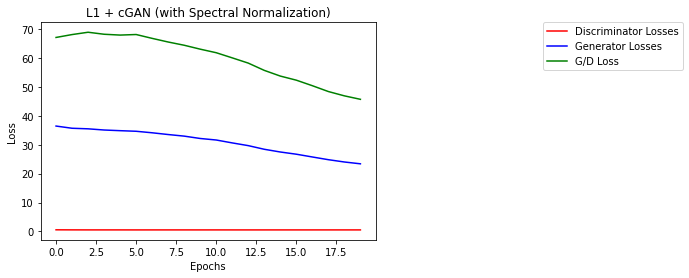

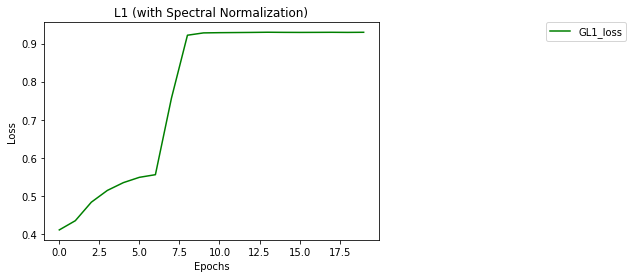

In [ ]:
# Plot the loss
##########--WRITE YOUR CODE HERE--##########
plt.plot(D_losses , 'r', label= 'Discriminator Losses')
plt.plot(G_losses , 'b', label= 'Generator Losses')
plt.plot(G_by_D_Loss , 'g', label= 'G/D Loss')

plt.legend(bbox_to_anchor=(1.5, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('L1 + cGAN (with Spectral Normalization)')
plt.show()

plt.plot(Final_Loss_GL1 , 'g', label= 'GL1_loss')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('L1 (with Spectral Normalization)')

plt.show()
##########-------END OF CODE-------##########

In [ ]:
# Visualization
# Please read Figure 4 in the pix2pix paper first

##########--WRITE YOUR CODE HERE--##########
import torchvision
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loader = DataLoader(buildData("test"), 1, shuffle=True)
testImage = []

for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device) 

    with torch.no_grad():
        newF1, newF2 = netG(a), netGL1(a)

    testImage += [a[0], b[0], newF2[0], newF1[0]]

    if j == 3:
        break

testImage = torch.stack(testImage).detach().cpu()
save_image(testImage, "testImage.png", nrow=4, normalize=True)

img = mpimg.imread('testImage.png')
plt.figure(figsize = (8, 8))
imgplot = plt.imshow(img)

plt.show()

##########-------END OF CODE-------##########

In [ ]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def inception_score(images, splits=10):
    ##########--WRITE YOUR CODE HERE--##########
    n = len(images)
    sample_size = 1
    if sample_size > 0 and n > sample_size:
      
      dataloader = torch.utils.data.DataLoader(images, sample_size=sample_size)
      prediction = np.zeros((n, 1000))

      def getPredictedValue (x):
          x = inception_model(x)
          return F.softmax(x).data.cpu().numpy()  

      for i, sample in enumerate(dataloader, 0):
          sample = sample[0].type(dtype)
          samplev = Variable(sample)
          sample_size_i = sample.size()[0]

          prediction [i*sample_size:i*sample_size + sample_size_i] = getPredictedValue (samplev)

      # Now compute the mean kl-div
      split_scores = []

      for k in range(splits):
          part = prediction [k * (n // splits): (k+1) * (n // splits), :]
          py = np.mean(part, axis=0)
          scores = []
          for i in range(part.shape[0]):
              pyx = part[i, :]
              scores.append(entropy(pyx, py))
          split_scores.append(np.exp(np.mean(scores)))
      
      ##########-------END OF CODE-------##########
      return np.mean(split_scores)

    else:
      return 0


# Get the translation on test set
##########--WRITE YOUR CODE HERE--##########
from torch.autograd import Variable
test_pred = []
test_pred_l1 = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = DataLoader(buildData("test"), 1, shuffle=True)

counter = 0
for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device)
    with torch.no_grad():
        facadeImage = netG(a)
        facadeImage_L1 = netGL1(a)
    test_pred.append(facadeImage)
    test_pred_l1.append(facadeImage_L1)

##########-------END OF CODE-------##########

inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
from IPython.display import HTML, display
import tabulate
table = [["Loss","Inception Score"],
         ["L1 + cGAN", f"{inception_s:.4f}"],
         ["L1", f"{inception_s_l1:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

## Submission guidelines
---
We will grade your homework based on your submitted notebook file. We will check the notebook for both results and code. Please make sure you run your code and print out the results in the notebook before submitting (we expect to see the results before running your code by ourselves.)

You submit your homework by first creating a ***google shared link*** of a folder for your homework (described below), and put that link into the ***text submission section*** of your homework submission on Blackboard. ([How to submit your link?](https://drive.google.com/file/d/16-FlPSiu5n-pRezLfcbAvgYxXtGtrs16))

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_hw**** in your Google Drive with your CS account (or your SBU account if you don't have a CS account). The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_hw5
        |---CSE527-22F-HW5.ipynb
```
Note that this folder should be in your Google Drive with your account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TAs' email: ***haoyuwu@cs.stonybrook.edu*** and ***vhnguyen@cs.stonybrook.edu***. Make sure that the TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box. ([How to share link?](https://drive.google.com/file/d/17R6j6yE8_8vXioOB3nNvbEPzxcI-rr_H) )

***IMPORTANT: Please do not make any modification to the folder and its files after the submission deadline***. (All modifications can be seen by the TAs via the revision history.) Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard.

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw1' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be delays in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.
